In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle as pkl
import imageio
import time
import os
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import models 
from keras.models import Model

from keras import layers
from keras.utils import to_categorical 
from keras.optimizers import RMSprop, Adam
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.models import load_model

from sklearn.metrics import confusion_matrix
import scikitplot as skplt

Using TensorFlow backend.
/home/e-bcivitci/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/e-bcivitci/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/e-bcivitci/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/e-bcivitci/anaconda3/lib/python3.7/sit

In [2]:
def loss_function(mdl):
    plt.plot(mdl.history['loss'])
    plt.plot(mdl.history['val_loss'])
    plt.title("Model Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'])
    plt.savefig("loss.png")
    plt.show()
def accuracy(mdl):
    plt.plot(mdl.history['accuracy'])
    plt.plot(mdl.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train','Test'])
    plt.savefig("acc.png")
    plt.show()

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
data_dir = '/home/e-bcivitci/Desktop/data'
lattice_size = 100
batch_size = 16
input_shape_img = (lattice_size,lattice_size,3)

In [5]:
training_set = train_datagen.flow_from_directory(
        data_dir,
        subset='training',
        target_size=(lattice_size, lattice_size),
        batch_size = batch_size, 
        class_mode='categorical',
        shuffle=True)
validation_set= train_datagen.flow_from_directory(
                                              data_dir,
                                              subset='validation', 
                                              target_size = (lattice_size,lattice_size),
                                              batch_size = batch_size, 
                                              class_mode='categorical',
                                              shuffle=True)



Found 39280 images belonging to 7 classes.
Found 9820 images belonging to 7 classes.


In [6]:
print(validation_set.class_indices)


{'T_1400-1000': 0, 'T_2000-1600': 1, 'T_2100-2060': 2, 'T_2250-2210': 3, 'T_2300-2260': 4, 'T_2500-2460': 5, 'T_4000-3600': 6}


In [7]:
num_class = 7

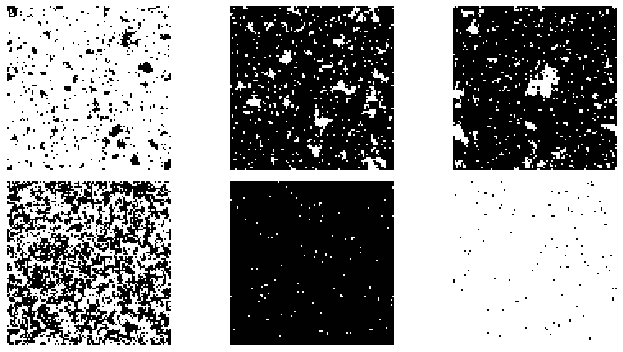

In [8]:
plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2,3,i+1)
    for x,y in validation_set:
        plt.imshow(x[0],cmap='hsv')
        #plt.title('y={}'.format(y[0]))
        plt.axis('off')
        break
plt.tight_layout()
plt.show()

In [9]:
# As usual we start by creating a sequential model
model_cnn = models.Sequential()

# We add the convolutional layer
model_cnn.add(Conv2D(filters=25, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last',input_shape=input_shape_img))
# The batch normalization: helping to generalize the training
model_cnn.add(BatchNormalization())
# Another convolutional layer
model_cnn.add(Conv2D(filters=25, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
# Batch normalization
model_cnn.add(BatchNormalization())
# Pooling for reducing overfitting
model_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same' ))
# We drop some neurons that will again help avoid overfitting
model_cnn.add(Dropout(0.25))

# We will add another series of the above with greater number of filters
model_cnn.add(Conv2D(filters=75, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
model_cnn.add(BatchNormalization())
model_cnn.add(Conv2D(filters=75, kernel_size=(3, 3), strides=1, padding='same', activation='relu', data_format='channels_last'))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size=(2, 2), padding='same', strides=2))
model_cnn.add(Dropout(0.25))

# Flatten will convert our results to 1D type
model_cnn.add(Flatten())
model_cnn.add(Dense(1000, activation='relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.25))
model_cnn.add(Dense(500, activation='relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.5))
# We have the final output layer
model_cnn.add(Dense(num_class, activation='softmax'))

In [10]:
model_cnn.compile(optimizer=RMSprop(learning_rate= 0.000005), loss="categorical_crossentropy", metrics=["accuracy"])
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 25)      700       
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 25)      100       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 25)      5650      
_________________________________________________________________
batch_normalization_2 (Batch (None, 100, 100, 25)      100       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 25)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 25)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 75)       

In [11]:
train_cnn = model_cnn.fit(training_set,
                          steps_per_epoch = training_set.samples// batch_size,
                          epochs = 200,
                          validation_data = validation_set,
                          validation_steps = validation_set.samples// batch_size)
model_cnn.save('cnn_200')


Epoch 1/200
2455/2455 [==============================] - 423s 172ms/step - loss: 1.2689 - accuracy: 0.5545 - val_loss: 2.0194 - val_accuracy: 0.4846
Epoch 2/200
2455/2455 [==============================] - 105s 43ms/step - loss: 0.8152 - accuracy: 0.6953 - val_loss: 2.7903 - val_accuracy: 0.4534
Epoch 3/200
2455/2455 [==============================] - 105s 43ms/step - loss: 0.6648 - accuracy: 0.7499 - val_loss: 2.6761 - val_accuracy: 0.4254
Epoch 4/200
2455/2455 [==============================] - 105s 43ms/step - loss: 0.5748 - accuracy: 0.7845 - val_loss: 2.6105 - val_accuracy: 0.3855
Epoch 5/200
2455/2455 [==============================] - 105s 43ms/step - loss: 0.5164 - accuracy: 0.8052 - val_loss: 3.8057 - val_accuracy: 0.3857
Epoch 6/200
2455/2455 [==============================] - 105s 43ms/step - loss: 0.4467 - accuracy: 0.8308 - val_loss: 2.3922 - val_accuracy: 0.3880
Epoch 7/200
2455/2455 [==============================] - 105s 43ms/step - loss: 0.4124 - accuracy: 0.8435 - va

2455/2455 [==============================] - 105s 43ms/step - loss: 0.0715 - accuracy: 0.9747 - val_loss: 4.2039 - val_accuracy: 0.4231
Epoch 55/200
2455/2455 [==============================] - 105s 43ms/step - loss: 0.0721 - accuracy: 0.9736 - val_loss: 3.4235 - val_accuracy: 0.4160
Epoch 56/200
2455/2455 [==============================] - 105s 43ms/step - loss: 0.0704 - accuracy: 0.9754 - val_loss: 3.5100 - val_accuracy: 0.4054
Epoch 57/200
2455/2455 [==============================] - 105s 43ms/step - loss: 0.0728 - accuracy: 0.9748 - val_loss: 6.7849 - val_accuracy: 0.4179
Epoch 58/200
2455/2455 [==============================] - 105s 43ms/step - loss: 0.0665 - accuracy: 0.9767 - val_loss: 2.6283 - val_accuracy: 0.4185
Epoch 59/200
2455/2455 [==============================] - 105s 43ms/step - loss: 0.0686 - accuracy: 0.9755 - val_loss: 3.8222 - val_accuracy: 0.4182
Epoch 60/200
2455/2455 [==============================] - 105s 43ms/step - loss: 0.0652 - accuracy: 0.9772 - val_loss: 

Epoch 109/200
2455/2455 [==============================] - 105s 43ms/step - loss: 0.0367 - accuracy: 0.9876 - val_loss: 2.7303 - val_accuracy: 0.5890
Epoch 110/200
2455/2455 [==============================] - 105s 43ms/step - loss: 0.0338 - accuracy: 0.9880 - val_loss: 3.8330 - val_accuracy: 0.5923
Epoch 111/200
2455/2455 [==============================] - 105s 43ms/step - loss: 0.0357 - accuracy: 0.9880 - val_loss: 1.7775 - val_accuracy: 0.6234
Epoch 112/200
2455/2455 [==============================] - 105s 43ms/step - loss: 0.0374 - accuracy: 0.9883 - val_loss: 2.4589 - val_accuracy: 0.5832
Epoch 113/200
2455/2455 [==============================] - 105s 43ms/step - loss: 0.0378 - accuracy: 0.9878 - val_loss: 3.5140 - val_accuracy: 0.6033
Epoch 114/200
2455/2455 [==============================] - 105s 43ms/step - loss: 0.0367 - accuracy: 0.9877 - val_loss: 0.9612 - val_accuracy: 0.6477
Epoch 115/200
2455/2455 [==============================] - 105s 43ms/step - loss: 0.0347 - accuracy:

2455/2455 [==============================] - 105s 43ms/step - loss: 0.0244 - accuracy: 0.9918 - val_loss: 1.4276 - val_accuracy: 0.6797
Epoch 164/200
2455/2455 [==============================] - 105s 43ms/step - loss: 0.0297 - accuracy: 0.9908 - val_loss: 2.6823 - val_accuracy: 0.6865
Epoch 165/200
2455/2455 [==============================] - 105s 43ms/step - loss: 0.0254 - accuracy: 0.9913 - val_loss: 1.4920 - val_accuracy: 0.6720
Epoch 166/200
2455/2455 [==============================] - 105s 43ms/step - loss: 0.0275 - accuracy: 0.9912 - val_loss: 2.2534 - val_accuracy: 0.6614
Epoch 167/200
2455/2455 [==============================] - 105s 43ms/step - loss: 0.0272 - accuracy: 0.9914 - val_loss: 1.7861 - val_accuracy: 0.6808
Epoch 168/200
2455/2455 [==============================] - 105s 43ms/step - loss: 0.0306 - accuracy: 0.9904 - val_loss: 1.2661 - val_accuracy: 0.6153
Epoch 169/200
2455/2455 [==============================] - 105s 43ms/step - loss: 0.0286 - accuracy: 0.9913 - val_

In [12]:
np.save("history_cnn_200",train_cnn.history)

In [13]:
test_loss_cnn, test_acc_cnn = model_cnn.evaluate(validation_set)
print("The accuracy of the model on the test set is ",100*test_acc_cnn, "%")

614/614 [==============================] - 5s 9ms/step
The accuracy of the model on the test set is  72.4949061870575 %


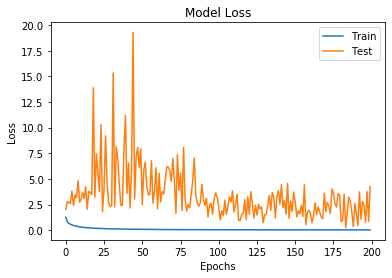

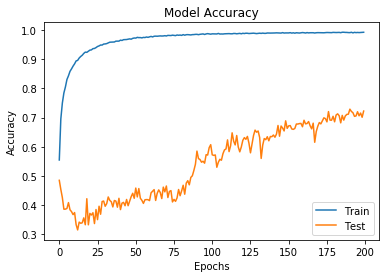

In [14]:
loss_function(train_cnn)
accuracy(train_cnn)

In [30]:
validation_set.reset()
Y_pred = model_cnn.predict_generator(validation_set,steps=np.ceil(nb_samples/batch_size))
classes = validation_set.classes[validation_set.index_array]
y_pred = np.argmax(Y_pred, axis=-1)
sum(y_pred==classes)/10000

0.7119

In [32]:
conf = confusion_matrix(validation_set.classes[validation_set.index_array],y_pred)
print(conf)

[[1540    0    0    0    0    0    0]
 [1487   53    0    0    0    0    0]
 [  30  334  924   11    0    0    1]
 [  19    1    2 1205   66    0    7]
 [  59    0    0  596  562   24   59]
 [   1    0    0    0    0 1295    4]
 [   0    0    0    0    0    0 1540]]


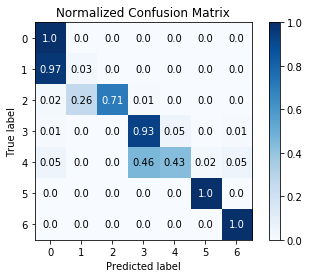

In [33]:
skplt.metrics.plot_confusion_matrix(
        validation_set.classes[validation_set.index_array],
        y_pred,normalize=True)

plt.savefig("confusion.png")
plt.show()